In [2]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os

# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True
import joblib

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year)).drop(columns=['Unnamed: 0'])

In [4]:
tornado = pd.concat([read_merged('tornado', year) for year in range(2015, 2023)])

In [5]:
tornado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306979 entries, 0 to 37884
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              306979 non-null  object 
 1   MONTH             306979 non-null  int64  
 2   LAT               306979 non-null  float64
 3   LON               306979 non-null  float64
 4   AVGDV             306979 non-null  int64  
 5   LLDV              306979 non-null  int64  
 6   MXDV              306979 non-null  int64  
 7   MXDV_HEIGHT       306979 non-null  int64  
 8   DEPTH             306979 non-null  float64
 9   MAX_SHEAR         306979 non-null  int64  
 10  MAX_SHEAR_HEIGHT  306979 non-null  float64
 11  COUNTY            306979 non-null  object 
 12  STATE             306979 non-null  object 
 13  POWER_OUTAGE      306979 non-null  bool   
dtypes: bool(1), float64(4), int64(6), object(3)
memory usage: 33.1+ MB


In [6]:
features = ['MONTH', 'LAT', 'LON', 'AVGDV', 'LLDV', 'MXDV', 'MXDV_HEIGHT', 'DEPTH', 'MAX_SHEAR', 'MAX_SHEAR_HEIGHT']
X,y = tornado[features], tornado['POWER_OUTAGE']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
X_tt, X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train)

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

# XGBoost

In [8]:
from xgboost import XGBClassifier
xgb_model = Pipeline([('resampler',RandomUnderSampler()), ('clf',XGBClassifier(objective = 'binary:logistic'))])

In [9]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'clf__max_depth': range (5, 17,  2),
    'clf__n_estimators': range(100, 440, 40),
    'clf__learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb_model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(X_tt, y_tt)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler', RandomUnderSampler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.3],
                         'clf__max_depth': range(5, 17, 2),
                         'clf__n_estimators': range(100, 440, 40)},
             scoring='f1', verbose=True)

In [10]:
best_model = grid_search.best_estimator_

In [13]:
import joblib
joblib.dump(best_model,'../../models/xgb_tornado.pkl')

['../../models/xgb_tornado.pkl']

# Random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_model = Pipeline([('resampler',RandomUnderSampler()), ('clf',RandomForestClassifier())])

In [16]:
parameters = {
    'clf__max_depth': range (5, 17,  2),
    'clf__n_estimators': range(100, 440, 40),
}

grid_search = GridSearchCV(rf_model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(X_tt, y_tt)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler', RandomUnderSampler()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': range(5, 17, 2),
                         'clf__n_estimators': range(100, 440, 40)},
             scoring='f1', verbose=True)

In [17]:
best_model = grid_search.best_estimator_

In [20]:
joblib.dump(best_model,'../../models/rf_tornado.pkl')

['../../models/rf_tornado.pkl']

# SGD

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
sgd = Pipeline([('resampler',RandomUnderSampler()), ('scaler', StandardScaler()), ('clf',SGDClassifier())])
sgd.fit(X_tt,y_tt)

Pipeline(steps=[('resampler', RandomUnderSampler()),
                ('scaler', StandardScaler()), ('clf', SGDClassifier())])

In [62]:
joblib.dump(sgd,'../../models/sgd_tornado.pkl')

['../../models/sgd_tornado.pkl']

# SVC

In [67]:
from sklearn.svm import LinearSVC
svc = Pipeline([('resampler',RandomUnderSampler()), ('scaler', StandardScaler()), ('clf',LinearSVC(dual='auto'))])
svc.fit(X_tt,y_tt)

Pipeline(steps=[('resampler', RandomUnderSampler()),
                ('scaler', StandardScaler()), ('clf', LinearSVC(dual='auto'))])

In [69]:
joblib.dump(svc,'../../models/svc_tornado.pkl')

['../../models/svc_tornado.pkl']

# Ensemble learning

In [8]:
from sklearn.ensemble import VotingClassifier
xgb_tornado = joblib.load('../../models/xgb_tornado.pkl')
rf_tornado = joblib.load('../../models/rf_tornado.pkl')
sgd_tornado = joblib.load('../../models/sgd_tornado.pkl')
svc_tornado = joblib.load('../../models/svc_tornado.pkl')
voting_tornado = VotingClassifier([('xgb', xgb_tornado), ('rf', rf_tornado), ('sgd', sgd_tornado), ('svc', svc_tornado)])

In [75]:
voting_tornado.fit(X_tt,y_tt)

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('resampler',
                                               RandomUnderSampler()),
                                              ('clf',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             imp...
                              Pipeline(steps=[('resampler',
                                               RandomUnderSampler()),
                                              ('clf',
                                               RandomForestClassifier(max_depth=15,
                                                                      n_estimators=340))])),
                             ('sgd',
                              Pipeline(steps=[('resampler',
                                               RandomUnderSampler()),
                                              ('scaler', StandardScaler()),
                                              ('clf', SGDClassifier())])),
                             ('svc',
                              Pipeline(steps=[('resampler',
                                               RandomUnderSampler()),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LinearSVC(dual='auto'))]))])

In [78]:
joblib.dump(voting_tornado, '../../models/xgb_rf_sgd_svc_tornado.pkl')

['../../models/xgb_rf_sgd_svc_tornado.pkl']

# Examining performance

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score, PrecisionRecallDisplay

In [12]:
xgb_tornado = joblib.load('../../models/xgb_tornado.pkl')
rf_tornado = joblib.load('../../models/rf_tornado.pkl')
sgd_tornado = joblib.load('../../models/sgd_tornado.pkl')
svc_tornado = joblib.load('../../models/svc_tornado.pkl')
xgb_rf_sgd_svc_tornado = joblib.load('../../models/xgb_rf_sgd_svc_tornado.pkl')

In [20]:
xgb_predictions = xgb_tornado.predict(X_val)
print('xGBoost results')
print('precision: ', precision_score(y_val,xgb_predictions))
print('recall: ', recall_score(y_val,xgb_predictions))
print('f1: ', f1_score(y_val,xgb_predictions))
print('accuracy score: ', accuracy_score(y_val,xgb_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,xgb_predictions))

xGBoost results
precision:  0.18178270371526695
recall:  0.9253079062375844
f1:  0.30386848457172677
accuracy score:  0.7827432457194047
balanced accuracy score:  0.85017541234626


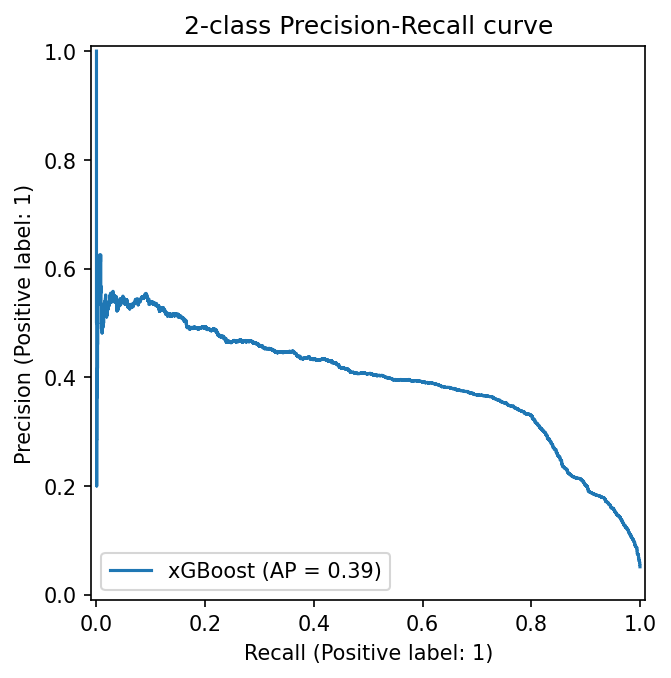

In [15]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_tornado, X_val, y_val, name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [21]:
rf_predictions = rf_tornado.predict(X_val)
print('Random forest results')
print('precision: ', precision_score(y_val,rf_predictions))
print('recall: ', recall_score(y_val,rf_predictions))
print('f1: ', f1_score(y_val,rf_predictions))
print('accuracy score: ', accuracy_score(y_val,rf_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,rf_predictions))

Random forest results
precision:  0.17250880146946274
recall:  0.8955105284068335
f1:  0.2892896104729513
accuracy score:  0.7745179876621129
balanced accuracy score:  0.8317466805124296


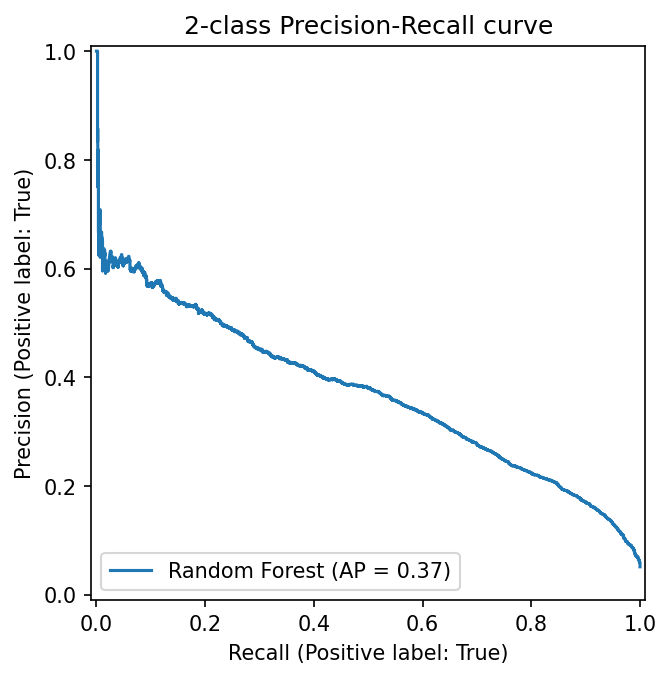

In [22]:
display = PrecisionRecallDisplay.from_estimator(
    rf_tornado, X_val, y_val, name="Random Forest")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [23]:
sgd_predictions = sgd_tornado.predict(X_val)
print('SGD results')
print('precision: ', precision_score(y_val,sgd_predictions))
print('recall: ', recall_score(y_val,sgd_predictions))
print('f1: ', f1_score(y_val,sgd_predictions))
print('accuracy score: ', accuracy_score(y_val,sgd_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,sgd_predictions))

SGD results
precision:  0.07222739981360671
recall:  0.6773937226857369
f1:  0.13053630899973204
accuracy score:  0.5375735488730989
balanced accuracy score:  0.6037075909566023


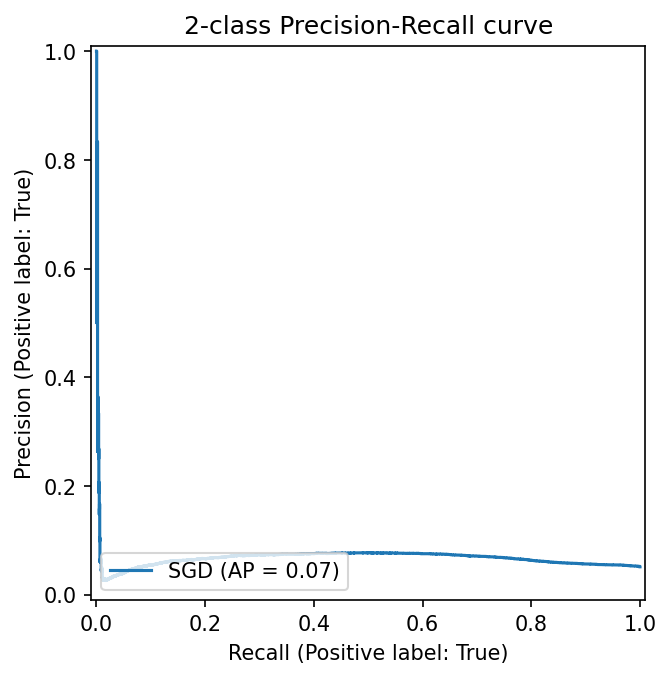

In [24]:
display = PrecisionRecallDisplay.from_estimator(
    sgd_tornado, X_val, y_val, name="SGD")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [25]:
svc_predictions = svc_tornado.predict(X_val)
print('SVC results')
print('precision: ', precision_score(y_val,svc_predictions))
print('recall: ', recall_score(y_val,svc_predictions))
print('f1: ', f1_score(y_val,svc_predictions))
print('accuracy score: ', accuracy_score(y_val,svc_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,svc_predictions))

SVC results
precision:  0.07233683087319936
recall:  0.646404449741756
f1:  0.13011315926266545
accuracy score:  0.5570779974346968
balanced accuracy score:  0.5993288343129382


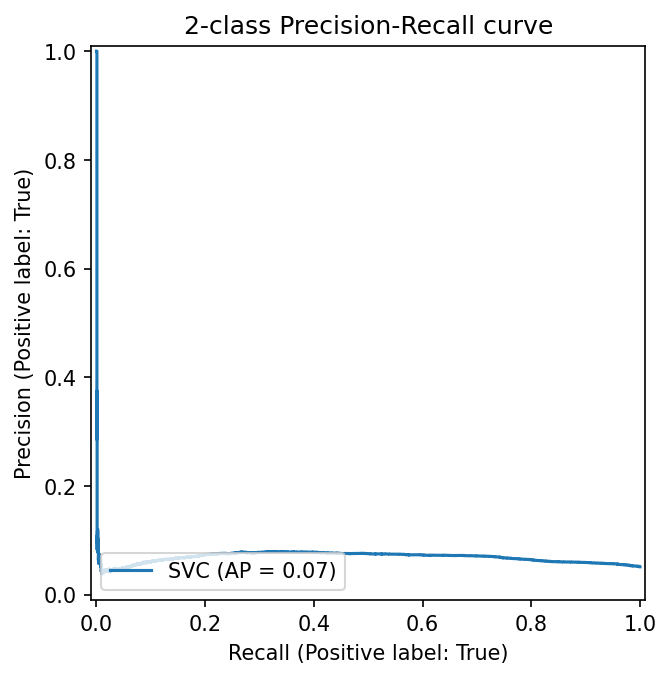

In [26]:
display = PrecisionRecallDisplay.from_estimator(
    svc_tornado, X_val, y_val, name="SVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [27]:
xgb_rf_sgd_svc_predictions = xgb_rf_sgd_svc_tornado.predict(X_val)
print('Ensemble results')
print('precision: ', precision_score(y_val,xgb_rf_sgd_svc_predictions))
print('recall: ', recall_score(y_val,xgb_rf_sgd_svc_predictions))
print('f1: ', f1_score(y_val,xgb_rf_sgd_svc_predictions))
print('accuracy score: ', accuracy_score(y_val,xgb_rf_sgd_svc_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,xgb_rf_sgd_svc_predictions))

Ensemble results
precision:  0.1591391890643761
recall:  0.6845450933651172
f1:  0.2582434052757794
accuracy score:  0.7984811775963516
balanced accuracy score:  0.7445901432490822
